# Data Preparation

In [ ]:
import pandas as pd
df = pd.read_csv("../data/repo_function_matched.csv")

In [2]:
len(df)

1078373

In [3]:
df.head()

,line,function,package,class,repo,path,author,commit,code
0,39,enable_eager_execution,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/noteb...,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,tf.enable_eager_execution()
1,54,square,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/noteb...,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,return tf.square(tf.sin(x))
2,54,sin,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/noteb...,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,return tf.square(tf.sin(x))
3,56,f,NaN,NaN,tensorflow,tensorflow/contrib/eager/python/examples/noteb...,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,assert f(pi/2).numpy() == 1.0
4,63,numpy,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/noteb...,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,assert tf.abs(grad_f(pi/2)[0]).numpy() < 1e-7


In [4]:
df.isna().sum()

line             0
function         2
package     624510
class       974982
repo             0
path             0
author         461
commit           0
code            37
dtype: int64

In [5]:
clean = df.drop(df[df.author.isnull()].index)
clean = clean.drop(clean[clean.function.isnull()].index)

In [6]:
clean.isna().sum()

line             0
function         0
package     624274
class       974563
repo             0
path             0
author           0
commit           0
code            37
dtype: int64

In [112]:
clean.describe(include=['object'])

,function,package,class,repo,path,author,commit,code,combined
count,1077910,453636,103347,1077910,1077910,1077910,1077910,1077873,1077910
unique,42238,3876,5867,3738,16524,7583,35233,481145,67654
top,print,matplotlib.pyplot,Sequential,deep-learning,note/s16a_synpipe_galaxy_1.ipynb,dr.guangtou@gmail.com,a58e916834e3f0adb2b91b8d12f5dc2f6711a008,"get_ipython().run_line_magic('matplotlib', 'inline')",print
freq,95520,108864,7188,20913,8589,16332,10897,7580,95500


In [7]:
import numpy as np
def combining(func, pack, c):
    name = func
    if c is not np.nan:
        name = ".".join([c, func])
    if pack is not np.nan:
        name = ".".join([pack, name])
    return name

In [8]:
clean['combined'] = clean.apply(lambda x: combining(x['function'], x['package'], x['class']), axis = 1)

In [165]:
clean.head()

,line,function,package,class,repo,path,author,commit,code,combined
0,39,enable_eager_execution,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/notebooks/automatic_differentiation.ipynb,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,tf.enable_eager_execution(),tensorflow.enable_eager_execution
1,54,square,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/notebooks/automatic_differentiation.ipynb,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,return tf.square(tf.sin(x)),tensorflow.square
2,54,sin,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/notebooks/automatic_differentiation.ipynb,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,return tf.square(tf.sin(x)),tensorflow.sin
3,56,f,NaN,NaN,tensorflow,tensorflow/contrib/eager/python/examples/notebooks/automatic_differentiation.ipynb,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,assert f(pi/2).numpy() == 1.0,f
4,63,numpy,tensorflow,NaN,tensorflow,tensorflow/contrib/eager/python/examples/notebooks/automatic_differentiation.ipynb,blamb@google.com,486b96a51d6b0b394edf77d182f7283a8ec03e0d,assert tf.abs(grad_f(pi/2)[0]).numpy() < 1e-7,tensorflow.numpy


In [10]:
authors = clean[['author','combined']].groupby(['author'])['combined'].apply(list).reset_index()

In [11]:
len(authors)

7583

In [12]:
authors.head()

,author,combined
0,--global,"[get_ipython, pandas.read_csv, pandas.set_inde..."
1,09zabeli@gmail.com,"[get_ipython, numpy.all, numpy.all, exp, numpy..."
2,0u812@users.noreply.github.com,"[tellurium.getBoundarySpeciesIds, tellurium.ge..."
3,0x4a50@gmail.com,"[numpy.exp, numpy.dot, numpy.dot, numpy.dot, t..."
4,1021036214@qq.com,"[int, input, int, input, int, input, print, ra..."


In [48]:
authors['combined'].apply(len).describe()

count    7583.000000 
mean     142.148226  
std      420.067820  
min      1.000000    
25%      13.000000   
50%      49.000000   
75%      139.000000  
max      16332.000000
Name: combined, dtype: float64

# Topic Modelling

In [92]:
#Import all necessary libraries
import glob
import pandas as pd
import numpy as np

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')
import _pickle as pickle

import re
import random
import collections

from gensim import corpora, models
import gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats

pyLDAvis.enable_notebook()
random.seed(1234)

from sklearn.metrics.cluster import adjusted_rand_score
pd.options.display.max_columns = None

In [141]:
%%time
#build gensim corpus
texts = authors['combined']
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in texts]

Wall time: 1.92 s


In [50]:
len(dictionary)

2359

In [153]:
%%time
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word = dictionary, num_topics= 3, passes=10, chunksize=100, update_every=0, alpha='auto', random_state=1)

Wall time: 50.9 s


In [17]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

In [154]:
%%time
# get descriptive stuff for all models
vis, df_topic = getModelResults(ldamodel, corpus, dictionary)

Wall time: 12.9 s


In [155]:
#print regular topics (top word probabilities)
ldamodel.print_topics()

[(0,
  '0.041*"matplotlib.pyplot.plot" + 0.021*"matplotlib.pyplot.show" + 0.018*"numpy.array" + 0.017*"matplotlib.pyplot.figure" + 0.016*"matplotlib.pyplot.ylabel" + 0.016*"matplotlib.pyplot.xlabel" + 0.015*"fit" + 0.014*"add" + 0.014*"enumerate" + 0.013*"numpy.arange"'),
 (1,
  '0.029*"str" + 0.026*"int" + 0.025*"numpy.array" + 0.019*"matplotlib.pyplot.plot" + 0.016*"list" + 0.014*"open" + 0.014*"matplotlib.pyplot.figure" + 0.013*"input" + 0.012*"numpy.zeros" + 0.012*"plot"'),
 (2,
  '0.025*"tensorflow.placeholder" + 0.023*"tensorflow.Variable" + 0.018*"numpy.array" + 0.012*"tensorflow.reduce_mean" + 0.011*"tensorflow.Session" + 0.011*"enumerate" + 0.010*"list" + 0.010*"int" + 0.010*"numpy.zeros" + 0.009*"open"')]

In [93]:
# Compute Perplexity
print('Perplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -5.88367854127155
Coherence Score:  0.45777386166758305


In [156]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.082548 -0.042979  1       1        39.319046
1     -0.042680  0.053184  2       1        41.598129
2      0.125228 -0.010205  3       1        19.082817, topic_info=     Category          Freq                                     Term  \
term                                                                   
70    Default  4170.000000   tensorflow.placeholder                    
61    Default  3454.000000   tensorflow.Variable                       
90    Default  3387.000000   input                                     
73    Default  2068.000000   tensorflow.reduce_mean                    
248   Default  1872.000000   tensorflow.Session                        
23    Default  8735.000000   int                                       
141   Default  15176.000000  matplotlib.pyplot.plot                    
367   Default  1384.000000   show_doc                                  
105   Default  9632.000000   str                                       
571   Default  1347.000000   tensorflow.matmul                         
74    Default  1330.000000   tensorflow.reshape                        
83    Default  1250.000000   tensorflow.zeros                          
595   Default  3631.000000   Sequential.add                            
1926  Default  1657.000000   datetime.datetime                         
63    Default  1036.000000   tensorflow.constant                       
82    Default  1064.000000   tensorflow.variable_scope                 
202   Default  2184.000000   display                                   
709   Default  1049.000000   tensorflow.global_variables_initializer   
68    Default  1099.000000   tensorflow.maximum                        
80    Default  847.000000    tensorflow.truncated_normal               
131   Default  2310.000000   time.time                                 
261   Default  5094.000000   fit                                       
171   Default  4766.000000   add                                       
567   Default  831.000000    tensorflow.cast                           
395   Default  869.000000    tensorflow.Session.run                    
38    Default  6058.000000   enumerate                                 
432   Default  5043.000000   plot                                      
640   Default  663.000000    tensorflow.reset_default_graph            
706   Default  610.000000    tensorflow.InteractiveSession.run         
317   Default  434.000000    folium.add_to                             
...       ...         ...                                  ...         
709   Topic3   737.690857    tensorflow.global_variables_initializer   
567   Topic3   595.841003    tensorflow.cast                           
706   Topic3   447.826996    tensorflow.InteractiveSession.run         
640   Topic3   478.693939    tensorflow.reset_default_graph            
68    Topic3   749.764954    tensorflow.maximum                        
708   Topic3   346.624542    tensorflow.equal                          
396   Topic3   402.466064    tensorflow.add                            
395   Topic3   573.089172    tensorflow.Session.run                    
71    Topic3   377.873718    tensorflow.random_uniform                 
710   Topic3   405.453644    tensorflow.name_scope                     
131   Topic3   946.582764    time.time                                 
566   Topic3   395.949188    tensorflow.argmax                         
48    Topic3   2042.560059   numpy.array                               
38    Topic3   1246.700928   enumerate                                 
432   Topic3   1083.292114   plot                                      
189   Topic3   1125.112061   numpy.zeros                               
24    Topic3   1202.578247   list                                      
26    Topic3   1093.582153   open                                      
23    Topic3   

In [88]:
#inspect first 10 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
topics_post = pd.concat([authors['author'], df_topic], axis=1)
topics_post.head(20)

,author,0,1,2,3,4,5,6,7,8,9
0,--global,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.985323
1,09zabeli@gmail.com,NaN,0.650625,NaN,NaN,0.342522,NaN,NaN,NaN,NaN,NaN
2,0u812@users.noreply.github.com,NaN,NaN,NaN,NaN,NaN,0.989180,NaN,NaN,NaN,NaN
3,0x4a50@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998154,NaN
4,1021036214@qq.com,NaN,0.996774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10246101+PMeira@users.noreply.github.com,NaN,NaN,NaN,NaN,NaN,0.885699,NaN,NaN,NaN,0.107010
6,1070251317@qq.com,NaN,0.997595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1098035510@qq.com,NaN,0.999230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1101318+mrw34@users.noreply.github.com,0.160273,0.098773,0.074469,0.078858,0.076820,0.128673,0.082352,0.058280,0.073302,0.168200
9,1109253641np@sina.com,NaN,0.997645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
pd.DataFrame(df_topic.idxmax(axis=1), columns=['cat'])['cat'].value_counts()

9    1877
0    1180
5    877 
1    670 
8    669 
3    525 
6    501 
2    490 
4    439 
7    355 
Name: cat, dtype: int64

In [150]:
%%time
cos = []
for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word = dictionary, num_topics= i, passes=10, chunksize=100, update_every=0, alpha='asymmetric', random_state=1)    
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    cos.append(coherence_lda)

Wall time: 24min 5s


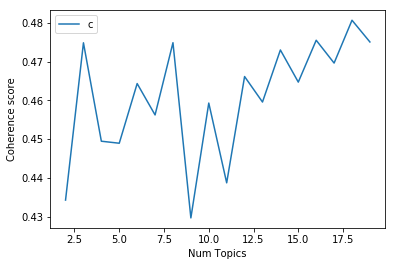

In [151]:
# Show graph
limit=20 
start=2
x = range(start, limit)
plt.plot(x, cos)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [152]:
cos

[0.4342720581927352,
 0.47482760034960414,
 0.4494494888736474,
 0.44893039403023555,
 0.46431295719384136,
 0.4562267068871669,
 0.47485139840164403,
 0.4296739797770362,
 0.4592889851225916,
 0.4387184143354998,
 0.46612482640066566,
 0.45955506567023635,
 0.4729754147987926,
 0.46469090504086685,
 0.4754845668776234,
 0.46960123063127845,
 0.48064052516712497,
 0.475040301957298]

## Removing All Matplotlib

In [166]:
no_frequent = clean.drop(clean[clean['package'] in ["matplotlib.pyplot","matplotlib"]].index)
no_frequent = no_frequent.drop(no_frequent[no_frequent['function'] in ["print","len"]].index)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [170]:
test = clean.drop(clean[clean['package'] == "matplotlib.pyplot"].index)
test = test.drop(clean[clean['package'] == "matplotlib"].index)

In [171]:
test_filter = test[['author','combined']].groupby(['author'])['combined'].apply(list).reset_index()

In [167]:
no_frequent.describe(include=['object'])

,function,package,class,repo,path,author,commit,code,combined
count,873526,344757,103301,873526,873526,873526,873526,873498,873526
unique,42202,3875,5867,3729,16289,7492,34119,405042,67370
top,len,numpy,Sequential,deep-learning,note/s16a_synpipe_galaxy_1.ipynb,dr.guangtou@gmail.com,a58e916834e3f0adb2b91b8d12f5dc2f6711a008,"get_ipython().run_line_magic('matplotlib', 'inline')",len
freq,30644,99968,7188,19269,6111,11770,10771,7580,30643


In [118]:
authors_filter = no_frequent[['author','combined']].groupby(['author'])['combined'].apply(list).reset_index()

In [124]:
len(authors_filter)

7492

In [119]:
authors_filter['combined'].apply(len).describe()

count    7492.000000 
mean     116.594501  
std      340.192428  
min      1.000000    
25%      12.000000   
50%      40.000000   
75%      116.000000  
max      11770.000000
Name: combined, dtype: float64

In [172]:
%%time
#build gensim corpus
texts_2 = test_filter['combined']
dictionary_2 = corpora.Dictionary(texts_2)
dictionary_2.filter_extremes(no_below=10, no_above=0.4)
dictionary_2.compactify()
corpus_2 = [dictionary_2.doc2bow(text) for text in texts_2]

Wall time: 1.73 s


In [176]:
%%time
lda_filter = gensim.models.ldamodel.LdaModel(corpus_2, id2word = dictionary_2, num_topics= 5, passes=10, chunksize=100, update_every=0, alpha='auto', random_state=1)

Wall time: 46.3 s


In [ ]:
lda_filter.print_topics()

In [179]:
%%time
# get descriptive stuff for all models
v_filter, df_filter = getModelResults(lda_filter, corpus_2, dictionary_2)

Wall time: 12.1 s


In [180]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
v_filter

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.029433 -0.042551  1       1        27.417839
1      0.140994  0.076129  2       1        15.331723
2     -0.014527  0.047893  3       1        18.657351
3     -0.136885  0.045512  4       1        15.496995
4      0.039851 -0.126983  5       1        23.096090, topic_info=     Category         Freq                    Term         Total  loglift  \
term                                                                        
90    Default  3335.000000  input                   3335.000000   30.0000   
163   Default  4211.000000  add                     4211.000000   29.0000   
563   Default  3221.000000  Sequential.add          3221.000000   28.0000   
23    Default  8842.000000  int                     8842.000000   27.0000   
61    Default  2776.000000  tensorflow.Variable     2776.000000   26.0000   
70    Default  3451.000000  tensorflow.placeholder  3451.000000   25.0000   
194   Default  2546.000000  display                 2546.000000   24.0000   
1826  Default  1712.000000  datetime.datetime       1712.000000   23.0000   
30    Default  2143.000000  Dense                   2143.000000   22.0000   
353   Default  1225.000000  show_doc                1225.000000   21.0000   
165   Default  3363.000000  pandas.head             3363.000000   20.0000   
214   Default  5635.000000  numpy.linspace          5635.000000   19.0000   
546   Default  1751.000000  pyplot.plot             1751.000000   18.0000   
6     Default  6431.000000  pandas.read_csv         6431.000000   17.0000   
17    Default  6528.000000  numpy.arange            6528.000000   16.0000   
112   Default  5111.000000  pandas.DataFrame        5111.000000   15.0000   
252   Default  5033.000000  fit                     5033.000000   14.0000   
73    Default  1728.000000  tensorflow.reduce_mean  1728.000000   13.0000   
929   Default  1443.000000  numpy.log10             1443.000000   12.0000   
239   Default  1575.000000  tensorflow.Session      1575.000000   11.0000   
412   Default  5198.000000  plot                    5198.000000   10.0000   
541   Default  1084.000000  tensorflow.matmul       1084.000000   9.0000    
349   Default  1071.000000  compile                 1071.000000   8.0000    
83    Default  1006.000000  tensorflow.zeros        1006.000000   7.0000    
213   Default  4511.000000  dict                    4511.000000   6.0000    
311   Default  1122.000000  HTML                    1122.000000   5.0000    
684   Default  819.000000   Dropout                 819.000000    4.0000    
431   Default  764.000000   Sequential              764.000000    3.0000    
690   Default  684.000000   Sequential.fit          684.000000    2.0000    
24    Default  7570.000000  list                    7570.000000   1.0000    
...       ...         ...              ...                 ...       ...    
6     Topic5   3584.162109  pandas.read_csv         6431.853027   0.8808    
178   Topic5   1120.443970  head                    1851.525269   0.9632    
177   Topic5   498.587524   groupby                 724.966919    1.0912    
164   Topic5   710.099609   pandas.drop             1124.101807   1.0062    
185   Topic5   835.684570   pandas.concat           1404.009399   0.9467    
252   Topic5   2389.475342  fit                     5033.494141   0.7205    
169   Topic5   450.180725   pandas.to_datetime      697.139465    1.0282    
274   Topic5   589.716003   train_test_split        1029.782959   0.9080    
411   Topic5   1300.340820  predict                 2970.954590   0.6392    
1167  Topic5   312.203522   pandas.rename           444.054565    1.1132    
26    Topic5   1964.890381  open                    6618.538086   0.2511    
271   Topic5   444.549927   score                   754.415039    0.9366    
277   Topic5   387.331207   RandomForestClassifier  615.791016    1.0019    
85    Topic5   1307.443604  zip      

In [173]:
%%time
cos_2 = []
for i in range(2,20):
    ldamodel_2 = gensim.models.ldamodel.LdaModel(corpus_2, id2word = dictionary_2, num_topics= i, passes=10, chunksize=100, update_every=0, alpha='asymmetric', random_state=1)    
    coherence_model_lda_2 = CoherenceModel(model=ldamodel_2, texts=texts_2, dictionary=dictionary_2, coherence='c_v')
    coherence_2 = coherence_model_lda_2.get_coherence()
    cos_2.append(coherence_2)

Wall time: 20min 25s


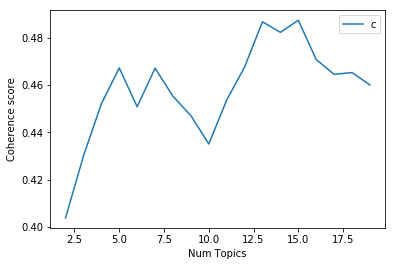

In [174]:
# Show graph
limit=20 
start=2
x = range(start, limit)
plt.plot(x, cos_2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [175]:
cos_2

[0.40380381088525963,
 0.43000805504279027,
 0.45203708581625923,
 0.46725190204056516,
 0.450796544088238,
 0.46713539682723576,
 0.45525764195671087,
 0.44706832454348405,
 0.43507766199658543,
 0.4536276181862046,
 0.46760379934698443,
 0.4867674334592066,
 0.4822977762182298,
 0.48741464075917895,
 0.4708002776202618,
 0.4645332468790504,
 0.46528257077792046,
 0.4600440036058848]